In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Parameters
s = 100                         # stock price
mu = 0.09                       # drift of stock price
sigma = 0.3                     # volatility of stock price
r = 0.04                        # risk-free rate
tau = 5                         # time to maturity, i.e. T - t
dt = 1 / 252                    # simulate daily price
num_simulation = int(1e5)       # number of simulation

## Underlying stock
Assume sotck price $S_t$ follows the geometic Brownian motion, i.e.

\begin{align*}
dS_t &= \mu S_t dt + \sigma S_t dW \\
\end{align*}

We then compute the dollarized Sharpe ratio (SR) by assuming that the financing cost is the interest rate $r$. The SR increases when there is a higher drift or longer time horizon, or when the interest rate or volatility decease.

The first five simulation results:

 [[100.          98.38916162 101.80304635 ... 213.31695782 211.55862844
  209.75033377]
 [100.         102.16062769 102.4540784  ... 172.99745009 181.56575174
  184.72866173]
 [100.          97.47146376  99.9892382  ... 119.28745033 122.97963043
  122.86558174]
 [100.          98.76119996 100.51190897 ... 210.15789044 212.63582802
  209.10437439]
 [100.          98.99559071  93.92096739 ...  59.53895645  58.25323525
   58.86309305]]




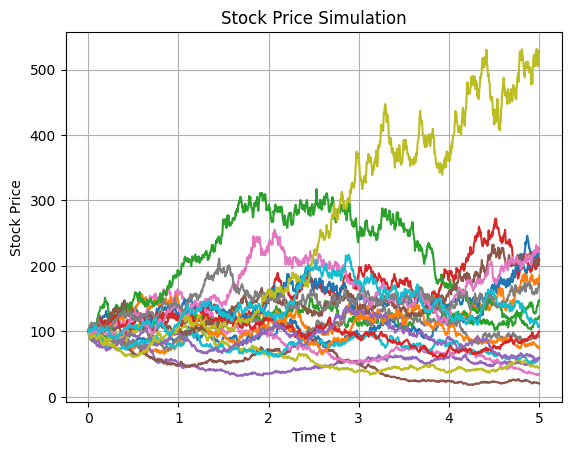

In [3]:
# Simulate sotck price
arr_drift = np.array([(mu - 0.5 * sigma**2) * i * dt for i in range(1, 252*tau+1)])
arr_diffusion = (sigma * np.sqrt(dt) * np.random.standard_normal((num_simulation, 252*tau))).cumsum(axis=1)
arr_s = s * np.exp(arr_drift + arr_diffusion)
arr_s = np.hstack((np.array([[s]*num_simulation]).T, arr_s))
print(f'The first five simulation results:\n\n {arr_s[:5]}\n\n')

# Plot the first twenty simulation results
t = np.linspace(0, tau, 252*tau+1)
for s_ in arr_s[:20]:
    plt.plot(t, s_)
plt.title('Stock Price Simulation')
plt.xlabel('Time t')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

### The dollarized Sharpe ratio
The dollarized Sharpe ratio (SR) is defined as the ratio of the expectation to the standard deviation of time $T$ absolute return:

\begin{align*}
SR :=& \frac{\text{Expectation of time $T$ absolute return}}{\text{Standard deviation of time $T$ absolute return}}\\
 =& \frac{E[S_T - S_te^{r\tau}]}{Std[S_T - S_te^{r\tau}]} \\
 =& \frac{S_t(e^{\mu\tau} - e^{r\tau})}{S_te^{\mu\tau}\sqrt{E[e^{-\sigma^2\tau + 2\sigma W_\tau}] - 1}]} \\
 =& \frac{1 - e^{(r-\mu)\tau}}{\sqrt{e^{\sigma^2\tau} - 1}}.
\end{align*}

The third equality is derived from the assumption of geometric Brownian motion, while the final equality is obtained through the fact of exponential martingale.

In [4]:
# Compute dollarized Sharpe ratio (SR)
SR_s = ( arr_s[:,-1] - s*np.exp(r*tau) ).mean() / ( arr_s[:,-1] - s*np.exp(r*tau) ).std()
print(f'The MC simulation: SR = {SR_s:.4f}')
print(f'The above formula: SR = {((1 - np.exp((r-mu)*tau)) / (np.exp(sigma**2*tau)-1)**0.5):.4f}')

The MC simulation: SR = 0.2954
The above formula: SR = 0.2934


### Sensitivity analysis of SR

SR tends to increase as drift $\mu$ or time to maturity $\tau$ increase, while it decreases when volatility $\sigma$ or risk-free rate $r$ increase. These relationships are generally intuitive, except for the impact of $\tau$. Loosely speaking, the return tends to grow proportionally to $\tau$, whereas the risk increases at a rate of approximately $\sqrt{\tau}$.


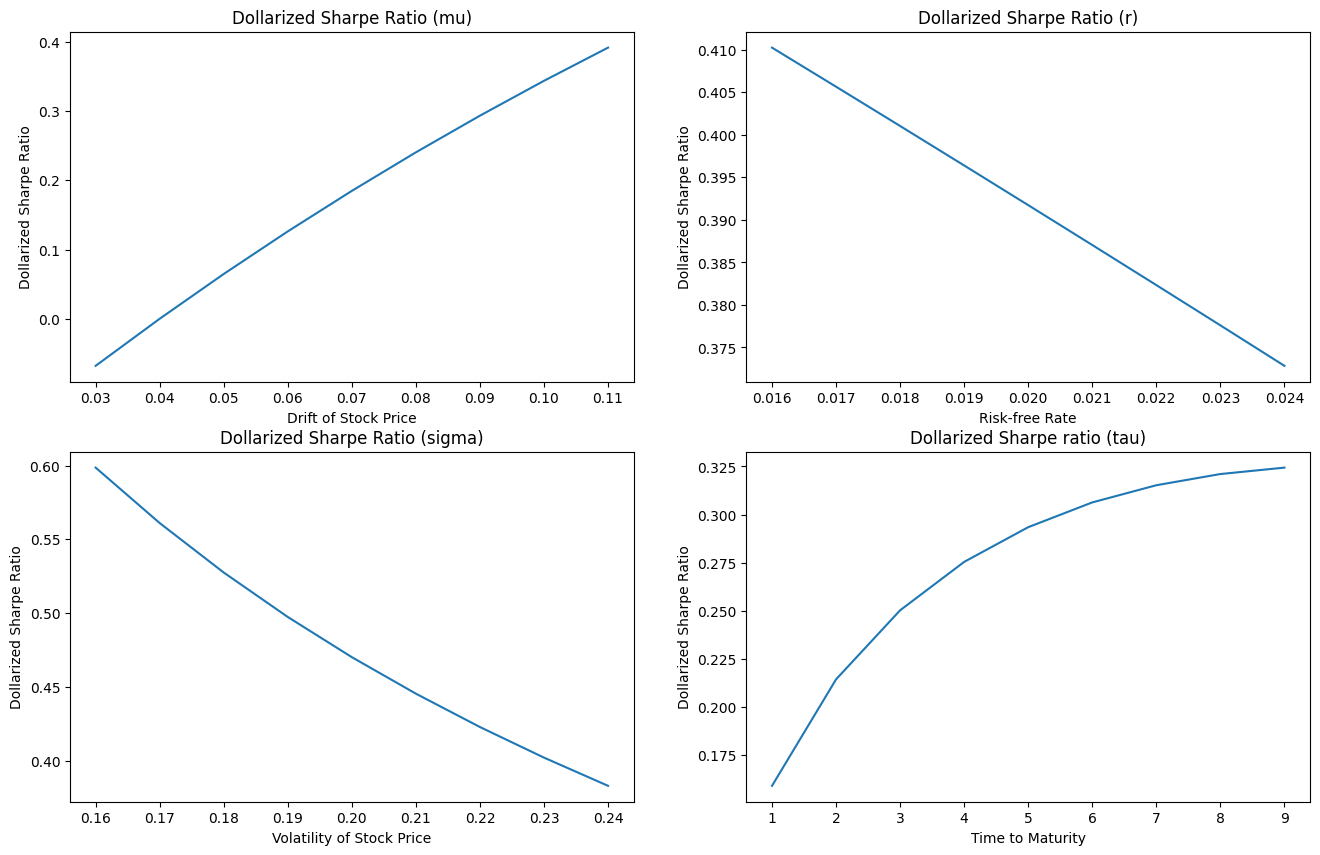

In [5]:
# Theoratical dollarized Sharpe ratio
def SR_s(mu, sigma, r, tau):
  return (1 - np.exp((r-mu)*tau)) / (np.exp(sigma**2*tau)-1)**0.5

# Sensitivity analysis
fig = plt.figure(figsize=(16,10))

arr_mu = np.linspace(0.03,0.11,9)
ax2 = fig.add_subplot(221)
ax2.plot(arr_mu, SR_s(arr_mu, sigma, r, tau), label='SR(mu)')
ax2.set_xlabel('Drift of Stock Price')
ax2.set_ylabel('Dollarized Sharpe Ratio')
ax2.set_title('Dollarized Sharpe Ratio (mu)')

arr_r = np.linspace(0.016,0.024,9)
ax3 = fig.add_subplot(222)
ax3.plot(arr_r, SR_s(mu, sigma, arr_r, tau), label='SR(r)')
ax3.set_xlabel('Risk-free Rate')
ax3.set_ylabel('Dollarized Sharpe Ratio')
ax3.set_title('Dollarized Sharpe Ratio (r)')

arr_sigma = np.linspace(0.16,0.24,9)
ax4 = fig.add_subplot(223)
ax4.plot(arr_sigma, SR_s(mu, arr_sigma, r, tau), label='SR(sigma)')
ax4.set_xlabel('Volatility of Stock Price')
ax4.set_ylabel('Dollarized Sharpe Ratio')
ax4.set_title('Dollarized Sharpe Ratio (sigma)')

arr_tau = np.linspace(1,9,9)
ax5 = fig.add_subplot(224)
ax5.plot(arr_tau, SR_s(mu, sigma, r, arr_tau), label='SR(tau)')
ax5.set_xlabel('Time to Maturity')
ax5.set_ylabel('Dollarized Sharpe Ratio')
ax5.set_title('Dollarized Sharpe ratio (tau)')

plt.show()

### Diversification with two stocks

Consider a portfolio consisting of two stocks. Since SR is invariant under leverage (assuming the financing cost is the risk-free rate), we can set the initial value of the portfolio to be $\$1$ without loss of generality.

Let's assume that the two stocks follow a two-dimensional geometric Brownian motion:

\begin{cases}
dS_1 = \mu_1 S_1 dt + \sigma_1 S_1 dW_1 \\
dS_2 = \mu_2 S_2 dt + \sigma_2 S_2 dW_2\\
dW_1dW_2= \rho dt
\end{cases}


Unless $\rho = 1$, the optimal portfolio should include both stocks.

In [6]:
# Parameters
s1, s2 = 100, 200                             # stock price
mu1, mu2 = 0.09, 0.17                         # drift of stock price
sigma1, sigma2 = 0.3, 0.4                     # volatility of stock price
rho = 0.4                                     # correlation coefficient

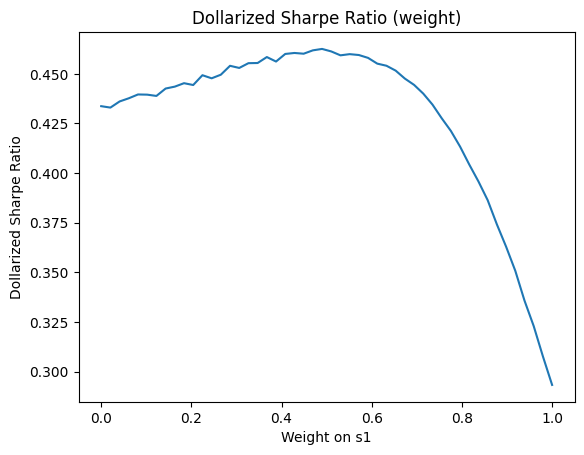

In [7]:
# Plot the MC simulation results given different weights on s1

mean, cov = [0, 0], [[1, rho], [rho, 1]]
def SR_portfolio(weight):
    w1, w2 = np.random.multivariate_normal(mean, cov, num_simulation*10).T
    arr_S1_T = s1 * np.exp((mu1 - 0.5*sigma1**2)*tau + sigma1 * tau**0.5 * w1)
    arr_S2_T = s2 * np.exp((mu2 - 0.5*sigma2**2)*tau + sigma2 * tau**0.5 * w2)

    return ( weight/s1 * arr_S1_T + (1-weight)/s2 * arr_S2_T - np.exp(r*tau) ).mean() / ( weight/s1 * arr_S1_T + (1-weight)/s2 * arr_S2_T - np.exp(r*tau) ).std()

arr_weight, list_SR_portfolio = np.linspace(0.0, 1.0, 50), []
for weight_ in arr_weight:
    list_SR_portfolio.append(SR_portfolio(weight_))
plt.plot(arr_weight, list_SR_portfolio)
plt.xlabel('Weight on s1')
plt.ylabel('Dollarized Sharpe Ratio')
plt.title('Dollarized Sharpe Ratio (weight)')

plt.show()

## Forward Contract
In fictionless market, no-aritrage condition ensures the ralationship between forward price $F_t$ and stock price $S_t$, i.e.

$F_t = S_te^{r(T-t)}$

We proceed to calculate SR, assuming again that the financing cost corresponds to the interest rate. It is important to note that the initial margin becomes irrelevant if the margin interest is paid at the same borrowing cost. The discussion regarding variation margin will be addressed in the futures contract section. Interestingly, it is found that the SR of a forward contract is equal to that of the underlying stock. This is because SR is invariant to leverage, and the forward contract, devoid of maintenance margin requirements, essentially represents a leveraged version of owning the underlying stock.

The first five simulation results:

 [[122.14027582 120.15371984 124.30305405 ... 213.38468824 211.59221184
  209.75033377]
 [122.14027582 124.75946778 125.097974   ... 173.05237864 181.59457399
  184.72866173]
 [122.14027582 119.03301905 122.08836696 ... 119.32532537 122.99915256
  122.86558174]
 [122.14027582 120.60805638 122.72655585 ... 210.22461783 212.66958242
  209.10437439]
 [122.14027582 120.89429644 114.67891683 ...  59.55786071  58.26248253
   58.86309305]]




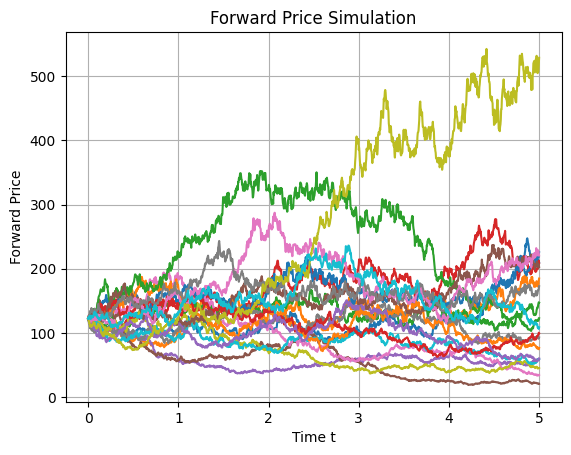

In [8]:
# Compute the corresponding forward price
arr_f = arr_s * np.exp([r*(tau-i*dt) for i in range(252*tau+1)])
print(f'The first five simulation results:\n\n {arr_f[:5]}\n\n')

# Plot the first twenty simulation results
t = np.linspace(0, tau, 252*tau+1)
for f_ in arr_f[:20]:
    plt.plot(t, f_)
plt.title('Forward Price Simulation')
plt.xlabel('Time t')
plt.ylabel('Forward Price')
plt.grid(True)

plt.show()

In [9]:
# Compute dollarized Sharpe ratio for long a forward contract
SR_f = ( arr_f[:,-1] - arr_f[:,0] ).mean() / ( arr_f[:,-1] - arr_f[:,0] ).std()
print(f'The MC simulation: SR = {SR_f:.4f}')

The MC simulation: SR = 0.2954


## Futures contract
Assume futures price obeys the same spot-forward relationship, i.e.

$ F_t = S_te^{r(T-t)} $

We then move on to calculating SR, assuming once again that the financing cost aligns with the interest rate. As mentioned earlier, initial margin is irrelevant here. Let's consider daily-settled full variation margin. It is important to observe that the previous day's profit and loss has a greater influence due to the time value, which distinguishes futures contracts from forward contracts. Essentially, owning the underlying stock and borrowing (or lending) money secured by the stock on a daily basis is equivalent to engaging in a futures contract.

In [10]:
# Compute time T value PnL
arr_pnl_T_value = np.diff( arr_f, prepend = s*np.exp(r*tau) ) * np.exp([r*(tau-i*dt) for i in range(252*tau+1)])

# Compute dollarized Sharpe ratio for long a futures contract
SR_fu = ( arr_pnl_T_value.sum(axis=1) ).mean() / ( arr_pnl_T_value.sum(axis=1) ).std()
print(f'The dollarized Sharpe ratio is: {SR_fu:.4f}')

The dollarized Sharpe ratio is: 0.2981


## European Call Option Contract
Assume the European call option price is charaterzied by the Black-Scholes formula:

\begin{align*}
C(S,K,r,T,\sigma) &= SN(d_1) - Ke^{-rT}N(d_2) \\
\end{align*}
where
\begin{align*}
d_1 &= \frac{1}{\sigma \sqrt{T}}\biggr[ \log \biggl( \frac{S}{K} \biggr) + \biggl( r + \frac{\sigma^2}{2} \biggr) T \biggr]\\
d_2 &= d_1 - \sigma\sqrt{T}
\end{align*}

Next, we proceed to calculate SR, assuming once again that the financing cost aligns with the interest rate. Additionally, we will experiment with the effect of the strike price $K$ on the SR.

In [11]:
# Black-Scholes formula
def black_scholes(s, K, r, tau, sigma, option_type):
    d1 = (np.log(s / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * tau**0.5)
    d2 = d1 - sigma * tau**0.5
    Q1 = norm.cdf(d1)
    Q2 = norm.cdf(d2)

    if option_type == 'call':
        option_price = s * Q1 - K * np.exp(-r * tau) * Q2
    elif option_type == 'put':
        option_price = K * np.exp(-r * tau) * (1-Q2) - s * (1-Q1)

    return option_price

K = 50   # Strike price
call_BS = black_scholes(s, K, r, tau, sigma, 'call')
print(f'Call option price (BS):{call_BS:.4f}')

# Compute dollarized Sharpe ratio for long a call
SR_c = (np.maximum(arr_s[:,-1]-K,0) - call_BS*np.exp(r*tau)).mean() / (np.maximum(arr_s[:,-1]-K,0) - call_BS*np.exp(r*tau)).std()
print(f'The MC simulation: SR = {SR_c:.4f}')

Call option price (BS):60.8205
The MC simulation: SR = 0.2885


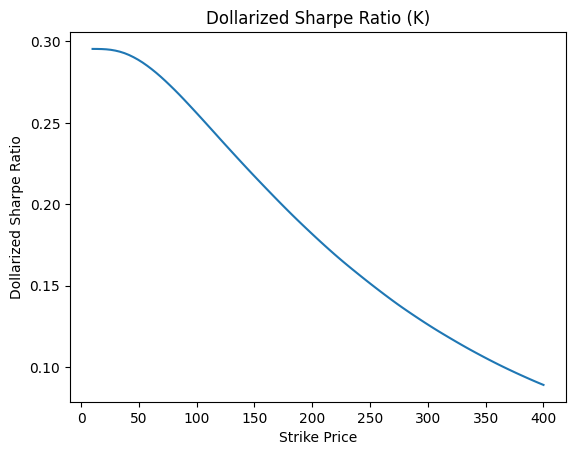

In [12]:
# The effect of strike price on SR
arr_K, list_SR_c = np.linspace(10,400,100), []
for K_ in arr_K:
    call_BS_ = black_scholes(s, K_, r, tau, sigma, 'call')
    list_SR_c.append((np.maximum(arr_s[:,-1]-K_,0) - call_BS_*np.exp(r*tau)).mean() / (np.maximum(arr_s[:,-1]-K_,0) - call_BS_*np.exp(r*tau)).std())

plt.plot(arr_K, list_SR_c, label = 'call')
plt.xlabel('Strike Price')
plt.ylabel('Dollarized Sharpe Ratio')
plt.title('Dollarized Sharpe Ratio (K)')

plt.show()